In [4]:

#IMPORT LIBRARIES

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#building connection with drive
import gdown
from google.colab import data_table


#LOAD DATASET

In [5]:
df = pd.read_csv('/content/Titanic-Dataset.csv')
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [6]:

print(df.head())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


##Summary of Data


In [7]:
def in_short(df) :
  return{
      "shape" :df.shape,
      "description" :df.describe,
      "values_missing" : df.isnull().sum(),
      "unique values" : df.nunique(),
      "data_type" : df.dtypes
  }
short_1 = in_short(df)
print(short_1)


{'shape': (891, 12), 'description': <bound method NDFrame.describe of      PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   

#Feature Engineering

In [8]:
#Title extraction from name

df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=True)
df['Title'] = df['Title'].replace(['Mlle','Ms'], 'Miss')
df['Title'] = df['Title'].replace(['Mme'], 'Mrs')
df['Title'] = df['Title'].replace(['Lady','Countess','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')
mapping_title=  {'Ms':1,'Master':2,'Mrs':3,'Miss':4,'Rare':5}
df['Title'] = df['Title'].map(mapping_title)
df['Title'] = df['Title'].fillna(0)

df['HasCabin']= df['Cabin'].notnull().astype(int)
df['FamilySize'] = df['SibSp'] + df['Parch'] +1
df['Age'] = df.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
df['Sex']= df['Sex'].map({'male':0, 'female': 1}).astype(int)
df= pd.get_dummies(df, columns= ['Embarked'], drop_first=True)

In [9]:
feature = ['Pclass','Sex','Embarked_Q','Embarked_S','Title',
           'Age','Fare','FamilySize','HasCabin','SibSp','Parch']

X= df[feature]
Y= df['Survived']

#TRAIN AND TEST SPLIT

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2, random_state= 42, stratify= Y)

In [11]:
#TRAIN MODEL USING RANDOM FOREST

rf= RandomForestClassifier(n_estimators= 100, random_state= 42)
rf.fit(X_train, Y_train)
rf_pred= rf.predict(X_test)
rd_ac = accuracy_score(Y_test, rf_pred)
print(f'Accuracy Score: {rd_ac}')

Accuracy Score: 0.7877094972067039


In [12]:
## TRAIN MODEL USING XGBOOST

xgb = XGBClassifier(use_label_encoder= False, eval_metric='logloss', random_state= 42)
xgb.fit(X_train, Y_train)
xgb_pred= xgb.predict(X_test)
xgb_ac = accuracy_score(Y_test, xgb_pred)
print(f'Accuracy Score: {xgb_ac}')

Accuracy Score: 0.7821229050279329


In [13]:
## EVALUATING BOTH TESTS
print("RANDOM FOREST")
print(classification_report(Y_test, rf_pred))
print("XGBOOST")
print(classification_report(Y_test, xgb_pred))

RANDOM FOREST
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       110
           1       0.73      0.71      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179

XGBOOST
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       110
           1       0.72      0.71      0.72        69

    accuracy                           0.78       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



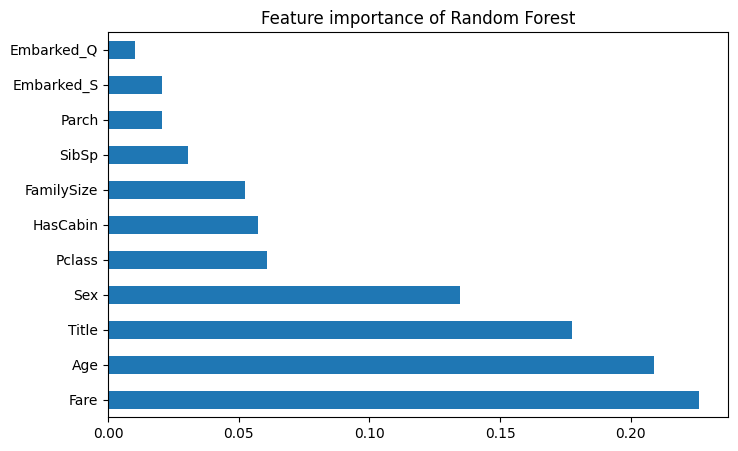

In [14]:
importance = pd.Series(rf.feature_importances_, index= X.columns)
importance.sort_values(ascending= False).plot(kind='barh',figsize=(8,5), title= "Feature importance of Random Forest")
plt.show()

##CROSS VALIDATION

In [15]:
rf_cv = cross_val_score(rf, X, Y, cv= 10).mean()
xgb_cv = cross_val_score(xgb, X, Y, cv= 10).mean()
print(f"Random forest cross accuracy: {rf_cv:.4f}")
print(f"XGB cross accuracy: {xgb_cv:.4f}")

Random forest cross accuracy: 0.8104
XGB cross accuracy: 0.8193


##CONDUSION MATRIX

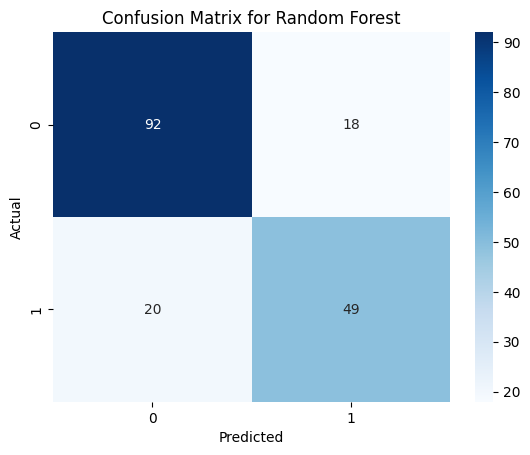

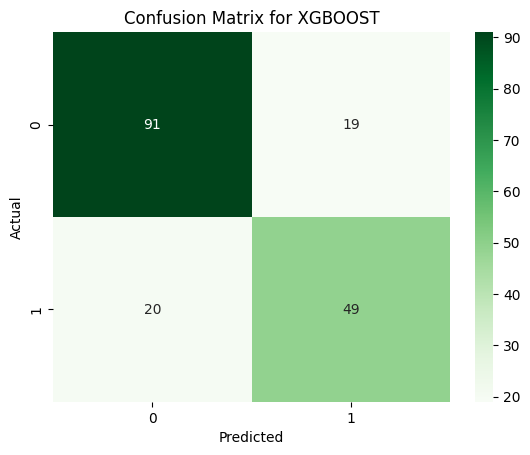

In [16]:
##RANDOM FOREST
sns.heatmap(confusion_matrix(Y_test, rf_pred), annot= True,fmt ='d', cmap= 'Blues')
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

##XGBOOST
sns.heatmap(confusion_matrix(Y_test, xgb_pred), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix for XGBOOST')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


##CLASSIFICATION REPORT

In [17]:
report_rf = classification_report(Y_test, rf_pred)
report_xgb = classification_report(Y_test, xgb_pred)
print("RANDOM FOREST")
print(report_rf)
print("XGBOOST")
print(report_xgb)

RANDOM FOREST
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       110
           1       0.73      0.71      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179

XGBOOST
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       110
           1       0.72      0.71      0.72        69

    accuracy                           0.78       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



##EDA (EXPLORATORY DATA ANALYSIS)

BOXPLOT

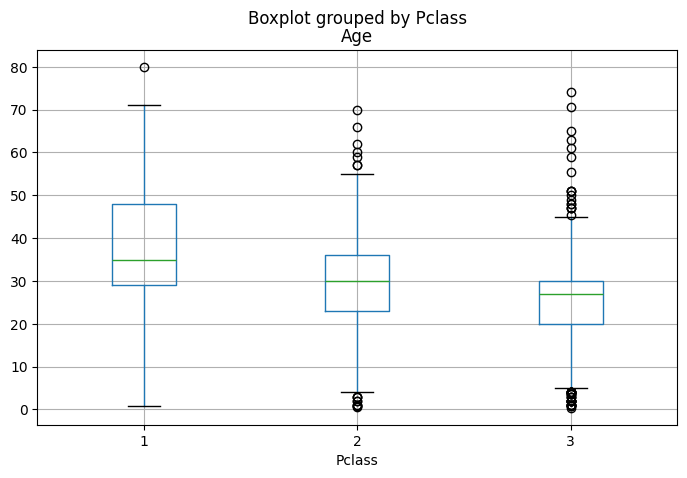

In [18]:
## AGE VS PCLASS
df.boxplot(column= 'Age',by= 'Pclass', figsize= (8,5))
plt.show()

##SURVIVAL BY EMBARKED




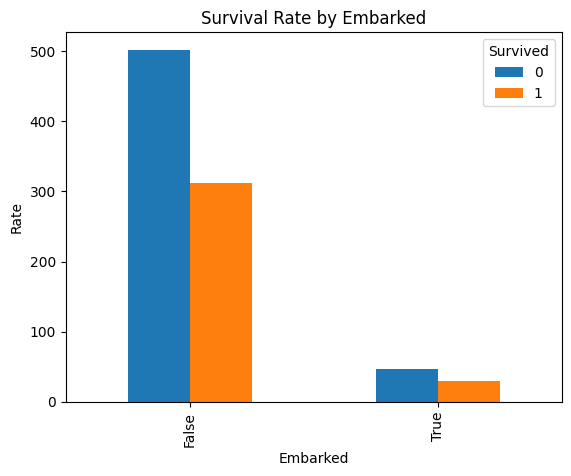

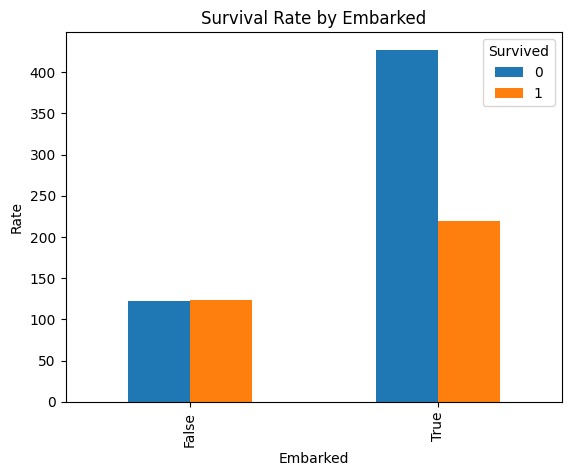

In [19]:
pd.crosstab(df['Embarked_Q'], df['Survived']).plot(kind= 'bar')
plt.title("Survival Rate by Embarked")
plt.xlabel("Embarked")
plt.ylabel("Rate")
plt.show()


pd.crosstab(df['Embarked_S'], df['Survived']).plot(kind= 'bar')
plt.title("Survival Rate by Embarked")
plt.xlabel("Embarked")
plt.ylabel("Rate")
plt.show()


###survived on the basis (SEX)

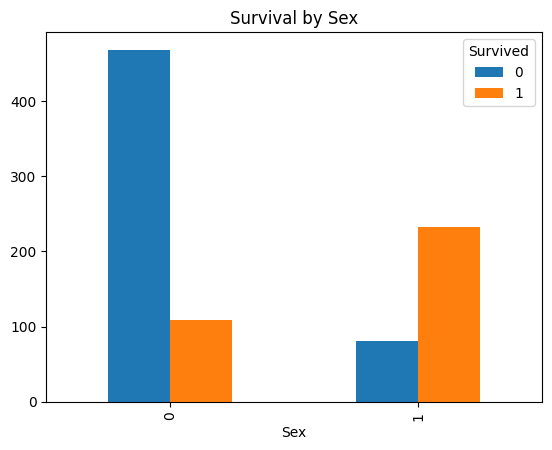

In [20]:
pd.crosstab(df['Sex'], df['Survived']).plot(kind='bar')
plt.title("Survival by Sex")
plt.show()

###SURVIVED BY PCLASS

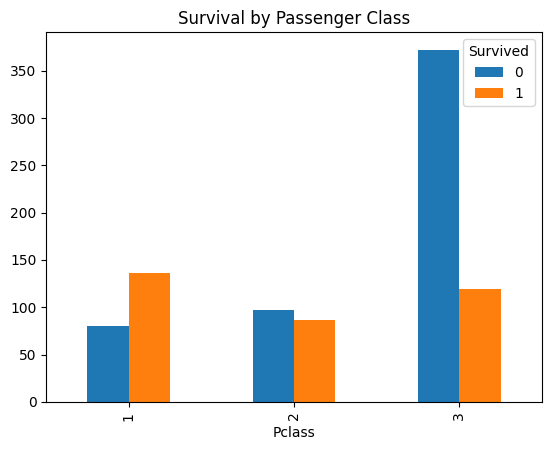

In [21]:
pd.crosstab(df['Pclass'], df['Survived']).plot(kind='bar')
plt.title("Survival by Passenger Class")
plt.show()

##CORRELATION HEATMAP

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix ')
plt.show()


##SUMMARY

In [23]:
print("Key Features:", feature)

print("Random Forest and XGBoost are both strong models for this task. The accuracy is 78%")


Key Features: ['Pclass', 'Sex', 'Embarked_Q', 'Embarked_S', 'Title', 'Age', 'Fare', 'FamilySize', 'HasCabin', 'SibSp', 'Parch']
Random Forest and XGBoost are both strong models for this task. The accuracy is 78%
